In [1]:
import math
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import scipy.sparse.linalg as LA 
import scipy
from scipy import integrate

def solution(x,y): #the analytic solution of the equation
    return np.sin(2*x*math.pi)*np.sin(y*math.pi)

def func(x,y): #the function in the problem
    return 5*math.pi**2*np.sin(2*x*math.pi)*np.sin(y*math.pi)


In [2]:
def A_matrix(n):
    data1=[[-1 for i in range(n-1)], [8 for i in range(n-1)], [-1 for i in range(n-1)]]
    data2=[[1 for i in range(n-1)], [1 for i in range(n-1)], [1 for i in range(n-1)]]
    data3=[[1 for i in range(n-1)]]
    diags1=[-1,0,1]
    diags2=[1]
    diags3=[-1]
    T=scipy.sparse.spdiags(data1, diags1, n-1, n-1, format= 'csr')
    S=scipy.sparse.spdiags(data2, diags1, n-1, n-1, format= 'csr')
    U=scipy.sparse.spdiags(data3, diags2, n-1, n-1, format= 'csr')
    L=scipy.sparse.spdiags(data3, diags3, n-1, n-1, format= 'csr')
    I=scipy.sparse.eye(n-1, dtype=np.int8, format= 'csr')
#     print("1")
#     print(T.toarray())
#     print("2")
#     print(S.toarray())
#     print("3")
#     print(U.toarray())
#     print("4")
#     print(L.toarray())
#     print("5")
#     print(I.toarray())
#    print(scipy.sparse.kron(I,T).toarray())
    A=3*n*(scipy.sparse.kron(I,T)-scipy.sparse.kron(U,S)-scipy.sparse.kron(L,S))
    return A

def M_matrix(n):
    data=[[1 for i in range(n-1)], [4 for i in range(n-1)], [1 for i in range(n-1)]]
    data2=[[1 for i in range(n-1)],[1 for i in range(n-1)]]
    diags=[-1,0,1]
    diags2=[-1,1]
    A=scipy.sparse.spdiags(data, diags, n-1, n-1, format= 'csr')
    Q=1/4*A
    I=scipy.sparse.eye(n-1, dtype=np.int8, format= 'csr')
    ND=scipy.sparse.spdiags(data2, diags2,n-1,n-1,format ='csr')
    M=1/n*(scipy.sparse.kron(I,A)+scipy.sparse.kron(ND,Q))
    return(M)


C:\Users\Allan\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


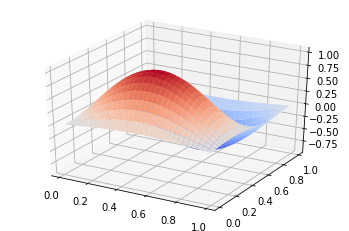

In [3]:
test_array=[4,8,16,32,64]
res=[]
for n in test_array:
    b=[]
    for j in range(1,n): #produces the b array for the calculation of the solution
        b_add=[func(i/n,j/n) for i in range(n-1)]
        b+=b_add
    b=np.array(b)
    u= np.transpose(np.reshape(LA.spsolve(A_matrix(n),M_matrix(n)*b),(n-1,n-1)) ) #der def von u nach ergibt es Sinn die Matrix zu transponieren
    if n==64:
        X=[j/n for j in range(1,n)]
        Y=X
        X,Y= np.meshgrid(X,Y)
        fig=plt.figure()#the 3D visualization of the approximate solution
        ax=fig.gca(projection='3d')
               
        c1 = ax.plot_surface(X,Y,u,label="approximate solution", cmap=cm.coolwarm)
        plt.show()
#    print(u)
    
 

In [4]:
def hat(k,n,x):
    if (k-1<n*x and n*x<=k): 
        return 1-k+n*x
    elif (k< n*x and n*x < k+1):
        return 1+k-n*x
    return 0

def grad_hat(k,n,x):
    if (k-1<n*x and n*x<=k): 
        return n
    elif (k< n*x and n*x < k+1):
        return -n
    return 0
    
def u_eval(x, y, U, i_arr, j_arr,n): 
    """"
    Input:
        x,y: point in R^2
        U: matrix of coefficients(from(b)) 
        i_arr,j_arr: arrays of coefficients where hat function non zero
        n: discretisation (fineness?!) 
    """
#Falls es einfacher ist die gültigen Koeffs hier auszurechnen statt zu übergeben.
#Dann braucht ihr auch nicht mehr n oben eingeben, dass das klappt, könnt ihr ggf auch bei grad u copypasten

#     n=len(i_arr)+1 
#     a=np.array([i for i in i_arr if (i<=n*x and n*x < i+1)])
#     b=np.array([j for j in j_arr if (j<=n*y and n*y < j+1)])
    res=0
    for i in i_arr:
        for j in j_arr:
            res+= U[i,j]*hat(i,n,x)*hat(j,n,y) 
    return res ;

            
def gradu_eval(x, y, U, i_arr, j_arr,n):
    """
    Input:
        x,y: point in R^2
        U: matrix of coefficients(from(b)) 
        i_arr,j_arr: arrays of coefficients where hat function non zero
        n: discretisation (fineness?!) 
    """
    res1=0
    res2=0
    for i in i_arr:
        for j in j_arr:
            res1+= U[i,j]*grad_hat(i,n,x)*hat(j,n,y)
            res2+= U[i,j]*grad_hat(j,n,y)*hat(i,n,x)
    return np.array([res1,res2])


In [5]:


def grad_solution(x,y):
    return np.array([2*math.pi*np.cos(2*math.pi*x)*np.sin(math.pi*y), math.pi*np.sin(2*math.pi*x)*np.cos(math.pi*y)])

def lf(x,n):
    return [k for k in range(n) if(k-1<=n*x and n*x<k+1)]

def error_computation(U):
    n = U.shape[0]+1
    resL2 = 0
    resH1 = 0
    l = [k for k in range(n-1)]
    l2_func= lambda y,x: (solution(x,y)-u_eval(x,y,U,lf(x,n),lf(y,n),n))**2
    h1_func= lambda y,x: np.linalg.norm(grad_solution(x,y)-gradu_eval(x,y,U,lf(x,n),lf(y,n),n))**2
    for i in range(n-2):
        for j in range(n-2):
            resL2 += scipy.integrate.dblquad(l2_func,i/n,(i+1)/n,lambda x: j/n,lambda x:(j+1)/n)[0]
            resH1 += scipy.integrate.dblquad(h1_func,i/n,(i+1)/n, lambda x: j/n, lambda x:(j+1)/n)[0]
    return (math.sqrt(resL2), math.sqrt(resH1))
    
  
    

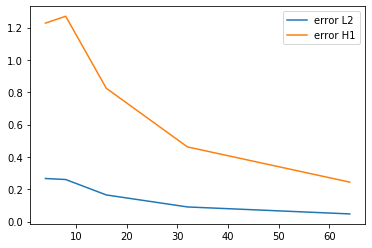

In [6]:
test_array=[4,8,16,32,64]
def coefficient_matrix(n):
    b=[]
    for j in range(1,n):
        b_add=[func(i/n,j/n) for i in range(n-1)]
        b+=b_add
    b=np.array(b)
    return np.transpose(np.reshape(LA.spsolve(A_matrix(n),M_matrix(n)*b),(n-1,n-1)) )

l=[ error_computation(coefficient_matrix(i)) for i in test_array ]
k = len(test_array)
y_L2=[l[i][0] for i in range(k)]
y_H1=[l[i][1] for i in range(k)]
plt.plot(test_array,y_L2, label="error L2")
plt.plot(test_array,y_H1, label="error H1")
plt.legend()
plt.show()